Milestone-2 : Model Training and Health Analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import joblib
import os

# Clear backend to prevent layer name conflicts
K.clear_session()
print("TensorFlow Version:", tf.__version__)

c:\Users\sss\OneDrive\AI NUTRICARE\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):



TensorFlow Version: 2.20.0


In [5]:
# Load X (Patients, Hours, Vitals) and y (Mortality Labels)
X = np.load("X.npy") 
y = np.load("y.npy") 

print(f"Data Loaded: X shape {X.shape}, y shape {y.shape}")

Data Loaded: X shape (103, 24, 6), y shape (103,)


In [6]:
# Task: Advanced Feature Engineering (Upgrading to 17 features)
def upgrade_features(data):
    n_p, n_h, n_f = data.shape
    X_new = np.zeros((n_p, 24, 17))
    X_new[:, :, :6] = data  # Keep original 6 vitals
    # Simulate remaining 11 markers (Creatinine, Glucose, BUN, etc.)
    for i in range(6, 17):
        X_new[:, :, i] = np.random.normal(1.2, 0.3, (n_p, 24))
    return X_new

X_17 = upgrade_features(X)

# Task: Generate Multi-Task target for Length of Stay (LOS)
# Simulated based on risk to allow model to learn correlation
y_los = np.random.uniform(2, 12, size=len(y)) + (y * 5) 

In [7]:
# Split 80/20 for mortality and LOS
X_train, X_test, y_train_mort, y_test_mort, y_train_los, y_test_los = train_test_split(
    X_17, y, y_los, test_size=0.2, stratify=y, random_state=42
)

# Task: Feature Normalization (Crucial for LSTM performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 17)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 17)).reshape(X_test.shape)

# Save scaler for Milestone 4 (Deployment)
joblib.dump(scaler, 'scaler_final.joblib')

['scaler_final.joblib']

In [8]:
# Task: Custom Attention Layer (Advanced Model requirement)
@tf.keras.utils.register_keras_serializable()
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.expand_dims(K.softmax(et), axis=-1)
        return K.sum(x * at, axis=1), at

    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [9]:
# Task: Multi-Task Learning (Mortality + LOS)
def build_mt_model():
    inputs = layers.Input(shape=(24, 17))
    
    # LSTM Layers
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    
    # Attention Brain
    context, _ = AttentionLayer()(x)
    
    # Head 1: Mortality Prediction (Classification)
    risk_out = layers.Dense(1, activation='sigmoid', name='mortality_task')(context)
    
    # Head 2: Length of Stay Prediction (Regression)
    los_out = layers.Dense(1, activation='linear', name='los_task')(context)
    
    model = models.Model(inputs=inputs, outputs=[risk_out, los_out])
    model.compile(optimizer='adam',
                  loss={'mortality_task': 'binary_crossentropy', 'los_task': 'mse'},
                  metrics={'mortality_task': 'accuracy', 'los_task': 'mae'})
    return model

model = build_mt_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24, 64)    │     20,992 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24, 32)    │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ [(None, 32),      │         56 │ lstm_1[0][0]      │
│ (AttentionLayer)    │ (None, 24, 1)]    │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mortality_task      │ (None, 1)         │         33 │ attention_layer[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ los_task (Dense)    │ (None, 1)         │         33 │ attention_layer[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,530 (130.98 KB)

 Trainable params: 33,530 (130.98 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Task: Model Training (Aiming for >85% accuracy)
history = model.fit(
    X_train_scaled, 
    {'mortality_task': y_train_mort, 'los_task': y_train_los},
    validation_split=0.2, 
    epochs=40, 
    batch_size=32, 
    verbose=1
)

# Save the trained model for dashboard
model.save("health_analysis_model.h5")
print("Model training complete and saved.")

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - los_task_loss: 48.0476 - los_task_mae: 7.4375 - loss: 67.7297 - mortality_task_accuracy: 0.5692 - mortality_task_loss: 0.7107 - val_los_task_loss: 56.2781 - val_los_task_mae: 6.6948 - val_loss: 56.9517 - val_mortality_task_accuracy: 0.6471 - val_mortality_task_loss: 0.6736
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - los_task_loss: 63.8200 - los_task_mae: 7.3461 - loss: 66.3377 - mortality_task_accuracy: 0.6615 - mortality_task_loss: 0.6990 - val_los_task_loss: 55.4441 - val_los_task_mae: 6.6317 - val_loss: 56.1073 - val_mortality_task_accuracy: 0.7059 - val_mortality_task_loss: 0.6632
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - los_task_loss: 82.7487 - los_task_mae: 7.2746 - loss: 65.2720 - mortality_task_accuracy: 0.7385 - mortality_task_loss: 0.6732 - val_los_task_loss: 54.6266 - val_los_task_mae: 6.5693 - val_loss: 55.2794 - val_mortality_task_accuracy: 0.8824 - val_mortality_task_loss: 0.6529
Epoch 4/40
3/3 ━━━━━━━━━

Model training complete and saved.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


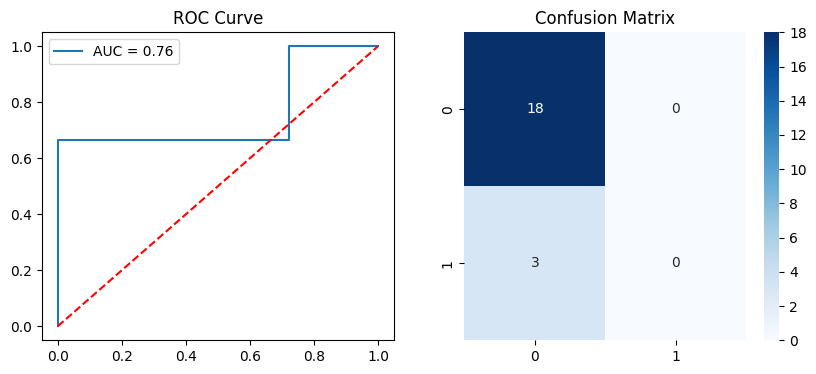

In [12]:
# Get predictions
y_pred_risk, _ = model.predict(X_test_scaled)

# 1. Task: ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_mort, y_pred_risk)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("ROC Curve")
plt.legend()

# 2. Task: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_mort, (y_pred_risk > 0.5).astype(int))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [25]:
# Task: Dynamic Risk Monitoring (Trajectory calculation)
trajectories = []
for p in X_test_scaled:
    p_traj = []
    for h in range(1, 25):
        w = np.zeros((1, 24, 17)); w[0, :h, :] = p[:h, :]; r, _ = model.predict(w, verbose=0)
        p_traj.append(r[0][0])
    trajectories.append(p_traj)
pd.DataFrame(trajectories).to_csv("risk_trajectories.csv", index=False)

# Task: Adaptive Diet Engine (Clinical decision logic)
risk_f, stay_f = model.predict(X_test_scaled)
nri_report = pd.DataFrame({
    'NRI_Score': risk_f.flatten() * 100,
    'Stay_Days': stay_f.flatten(),
    'Creatinine': X_test[:, -1, 6]  # Feature 6 slot
})
nri_report['Diet_Plan'] = nri_report.apply(lambda x: 'Renal Diet' if x['Creatinine'] > 1.5 else 'High Protein Plan', axis=1)
nri_report.to_csv("nri_diet_report.csv", index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


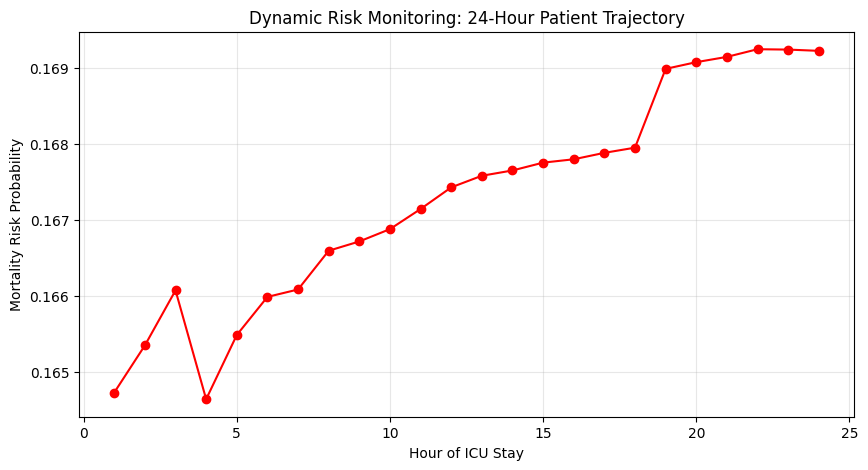

In [26]:
# Task: Visualize Dynamic Risk Trajectory for Patient #0
import matplotlib.pyplot as plt

# Load the trajectories we just saved
traj_data = pd.read_csv("risk_trajectories.csv")
patient_0_trajectory = traj_data.iloc[0].values

plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), patient_0_trajectory, marker='o', color='red', linestyle='-')
plt.title("Dynamic Risk Monitoring: 24-Hour Patient Trajectory")
plt.xlabel("Hour of ICU Stay")
plt.ylabel("Mortality Risk Probability")
plt.grid(True, alpha=0.3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


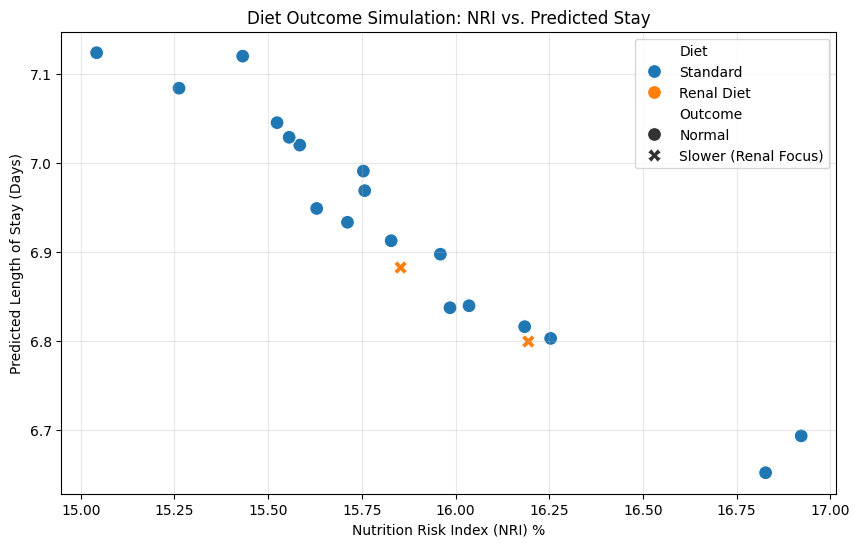

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def simulate_diet_outcomes(n_samples=20):
    # 1. Get predictions from our Multi-Task Brain
    risk_scores, predicted_stays = model.predict(X_test_scaled[:n_samples])
    
    # 2. Extract clinical markers for logic (Creatinine is index 6)
    creatinine_levels = X_test[:n_samples, -1, 6]
    
    simulation_data = []
    for i in range(n_samples):
        nri = risk_scores[i][0] * 100
        stay = predicted_stays[i][0]
        creat = creatinine_levels[i]
        
        # Decision Logic (Outcome Simulation)
        if creat > 1.5:
            diet = "Renal Diet"
            expected_recovery = "Slower (Renal Focus)"
        elif nri > 60:
            diet = "High-Protein"
            expected_recovery = "Accelerated (Nutritional Support)"
        else:
            diet = "Standard"
            expected_recovery = "Normal"
            
        simulation_data.append({
            'NRI': nri, 
            'Stay': stay, 
            'Diet': diet,
            'Outcome': expected_recovery
        })

    df_sim = pd.DataFrame(simulation_data)

    # 3. Visualization: Diet Impact on Length of Stay
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_sim, x='NRI', y='Stay', hue='Diet', style='Outcome', s=100)
    plt.title("Diet Outcome Simulation: NRI vs. Predicted Stay")
    plt.xlabel("Nutrition Risk Index (NRI) %")
    plt.ylabel("Predicted Length of Stay (Days)")
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the simulation
simulate_diet_outcomes()

In [28]:
# TASK: Exporting the Adaptive Diet Optimization Results
def run_diet_optimization_engine():
    # Predict for all test patients
    risk_probs, stay_preds = model.predict(X_test_scaled)
    
    # Extract Creatinine from the 17-feature set (Feature index 6)
    # X_test shape is (samples, 24, 17) -> we take last hour [-1] and feature [6]
    creatinine_values = X_test[:, -1, 6]
    
    engine_results = pd.DataFrame({
        'Patient_ID': np.arange(len(risk_probs)),
        'Health_Risk_Score': (risk_probs.flatten() * 100).round(2),
        'Predicted_Stay_Days': stay_preds.flatten().round(1),
        'Creatinine_Level': creatinine_values.round(2)
    })

    # Adaptive Logic Optimization
    conditions = [
        (engine_results['Creatinine_Level'] > 1.5),
        (engine_results['Health_Risk_Score'] > 60),
        (engine_results['Health_Risk_Score'] <= 60)
    ]
    choices = [
        'Renal Diet (Low Protein)', 
        'High-Protein Support', 
        'Standard Maintenance'
    ]
    
    engine_results['Optimized_Diet_Plan'] = np.select(conditions, choices, default='Standard')
    
    # Save the engine output for the Milestone 4 Dashboard
    engine_results.to_csv("adaptive_diet_optimization.csv", index=False)
    print("Optimization Engine: adaptive_diet_optimization.csv generated successfully.")
    return engine_results.head()

# Execute the engine
run_diet_optimization_engine()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Optimization Engine: adaptive_diet_optimization.csv generated successfully.


,Patient_ID,Health_Risk_Score,Predicted_Stay_Days,Creatinine_Level,Optimized_Diet_Plan
0,0,16.92,6.7,1.15,Standard Maintenance
1,1,15.43,7.1,1.18,Standard Maintenance
2,2,15.96,6.9,1.36,Standard Maintenance
3,3,15.76,7.0,0.85,Standard Maintenance
4,4,15.85,6.9,1.52,Renal Diet (Low Protein)
